# ID5059 Group Project: Temperature Prediction

### 2-1 Modelling: Neural Network

In [12]:
# import libraries
# load data
from pathlib import Path
import pandas as pd

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# modelling and evaluation
import numpy as np
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# set seed for numpy
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### 2-1.1.1 Load Data

In [2]:
# function reads in data from file
def load_data(file_name, file_path = "./", deliniator = ","):
    path = Path() / file_path / file_name; print(path)
    if not path.is_file():
        raise Exception("File not found")

    return pd.read_csv(path, sep = deliniator)
    #return np.loadtxt(path, delimiter = deliniator)

"""
# reads in csv file containing data
file_path = "./"

file_name = "x_train.csv"
x_train = load_data(file_name, file_path = file_path, deliniator = ",")

file_name = "y_train.csv"
y_train = load_data(file_name, file_path = file_path, deliniator = ",")

file_name = "x_valid.csv"
x_valid = load_data(file_name, file_path = file_path, deliniator = ",")

file_name = "y_valid.csv"
y_valid = load_data(file_name, file_path = file_path, deliniator = ",")
"""

file_path = "./"

file_name = "era5_train_prepared_with_no_nearby.csv"
data_train = load_data(file_name, file_path = file_path, deliniator = ",")

file_name = "era5_val_prepared_with_no_nearby.csv"
data_valid = load_data(file_name, file_path = file_path, deliniator = ",")

era5_train_prepared_with_no_nearby.csv
era5_val_prepared_with_no_nearby.csv


In [3]:
# printing the heads of the training and validation sets to confirm that they are the same for each model
data_train.head(2)

,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m,year,month,day,hour,season
0,56.00,-0.75,0.000000,2.117569,8.345276,101296.94,3.671143,10.726196,0.398621,0.0,290.68433,2018,7,31,17,3
1,58.75,-5.75,0.000913,5.980820,9.166794,100456.50,8.365173,11.827179,1.000000,1.0,287.38440,2018,8,21,20,3


In [4]:
data_valid.head(2)

,latitude,longitude,tp,u10,v10,sp,u100,v100,tcc,ptype,t2m,year,month,day,hour,season
0,51.25,-7.25,0.000000,5.886337,-0.648453,101456.50,6.440597,-0.707596,0.025299,0.0,283.5376,2018,5,13,4,2
1,52.50,-3.75,0.000005,-4.333618,1.897888,99209.44,-7.078690,3.492432,1.000000,1.0,283.2859,2018,11,16,22,4


#### 2-1.1.2 Pipeline to convert to numpy for keras

In [5]:
# pipeline included to convert the dataset from pandas to numpy for keras compatibility
one_hot_columns = ["year", "month", "day", "hour", "season", "ptype"]
all_columns = data_train.loc[:, data_train.columns != "t2m"].columns

"""
datetime_pipeline = Pipeline([
    ("extract_datetime", FunctionTransformer(extract_datetime_features, validate=False)),
    ("one_hot_encode", OneHotEncoder(handle_unknown="ignore", sparse_output = False))
])
"""

# deals with numeric attributes
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler())
])

# 
preprocessor = ColumnTransformer([
    #("datetime", datetime_pipeline, ["valid_time"]),
    #("encode_ptype", OneHotEncoder(handle_unknown="ignore", sparse_output = False), ["ptype"]),
    ("encode data", OneHotEncoder(handle_unknown="ignore", sparse_output = False), one_hot_columns),
    ("numeric", numeric_pipeline, all_columns)
    #("drop_columns", "drop", columns_to_drop)
], remainder = "drop", 
sparse_threshold = 0.0
)

full_pipeline = Pipeline([
    ("preprocess", preprocessor)
])

# separating the response variable before using the pipeline on the training and validation sets
y_train = data_train["t2m"].to_numpy()
y_valid = data_valid["t2m"].to_numpy()

# using the pipeline on the training and validation sets
x_train = full_pipeline.fit_transform(data_train.drop("t2m", axis = 1))
x_valid = full_pipeline.transform(data_valid.drop("t2m", axis = 1))

In [6]:
# checks to ensure that all of the data types are compatible for use in modelling
type(x_train) == type(x_valid) == type(y_train) == type(y_valid)

True

#### 2-1.2 Implement Neural Network

In [7]:
# current version of tensor flow incompatible with version of python agreed upon in group contract
# hence no R2 function
# hence manual implementation

# calculates the R2 score
@keras.utils.register_keras_serializable()
def R2(yTrue, yPredicted):
    residual = keras.backend.sum( (yTrue - yPredicted) ** 2 )
    total = keras.backend.sum( (yTrue - keras.backend.mean(yTrue)) ** 2 )
    return 1 - (residual / ( total + keras.backend.epsilon() ))

In [8]:
# creates a function to define the neural network so that it can be used in a grid search
def create_neural_network(learning_rate=0.001):
    model = keras.models.Sequential()
    model.add( keras.layers.Dense(24, input_shape = (x_train.shape[1], ), activation = "relu",
                                  kernel_regularizer = keras.regularizers.L1L2(l1 = 0.01 , l2 = 0.01))
                                  )
    model.add( keras.layers.Dense(16, activation = "relu",
                                  kernel_regularizer = keras.regularizers.L1L2(l1 = 0.01 , l2 = 0.01))
                                  )
    model.add( keras.layers.Dense(8, activation = "relu",
                                  kernel_regularizer = keras.regularizers.L1L2(l1 = 0.01 , l2 = 0.01))
                                  )
    model.add( keras.layers.Dense(1, activation = "linear") )

    model.compile(loss = "mse",
                  optimizer = keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07),
                  metrics = [keras.metrics.MeanSquaredError(), R2] )
    return model

#### 2-1.3 Grid Search for Optimal Hyperparameters

In [9]:
with tf.device('/GPU:0'):
    neural_network = keras.wrappers.scikit_learn.KerasRegressor(build_fn = create_neural_network)

    parameter_grid = {
        "batch_size": [16, 32],
        "epochs": [5],
        "shuffle": [True, False],
        "learning_rate": [0.001, 0.01],
        "verbose": [1]
    }

    k = 3
    grid = GridSearchCV(estimator = neural_network,
                        param_grid = parameter_grid,
                        scoring = ["neg_mean_squared_error", "r2"],
                        refit = "neg_mean_squared_error",
                        n_jobs = 1,
                        cv = k,
                        verbose = 3)


    N0 = 0.01
    N = int(N0 * x_train.shape[0])
    sample_indices = np.random.choice(a = range(0, x_train.shape[0]), size = N, replace = False)

    print(x_train.shape)
    print(x_train[sample_indices].shape)
    grid.fit(x_train[sample_indices], y_train[sample_indices])

C:\Users\leewi\AppData\Local\Temp\ipykernel_5728\4213043973.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = keras.wrappers.scikit_learn.KerasRegressor(build_fn = create_neural_network)


(10631136, 95)
(106311, 95)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Epoch 1/5
4430/4430 [==============================] - 12s 2ms/step - loss: 3454.2424 - mean_squared_error: 3445.8115 - R2: -175.2127
Epoch 2/5
4430/4430 [==============================] - 11s 2ms/step - loss: 13.9848 - mean_squared_error: 6.0901 - R2: 0.7084
Epoch 3/5
4430/4430 [==============================] - 11s 2ms/step - loss: 12.7069 - mean_squared_error: 5.6714 - R2: 0.7261
Epoch 4/5
4430/4430 [==============================] - 11s 2ms/step - loss: 11.7311 - mean_squared_error: 5.3922 - R2: 0.7387
Epoch 5/5
2215/2215 [==============================] - 2s 709us/step
[CV 1/3] END batch_size=16, epochs=5, learning_rate=0.001, shuffle=True, verbose=1; neg_mean_squared_error: (test=-5.135) r2: (test=0.783) total time=  56.8s
Epoch 1/5
4430/4430 [==============================] - 11s 2ms/step - loss: 3251.5410 - mean_squared_error: 3244.4424 - R2: -163.6913
Epoch 2/5
4430/4430 [==================

In [52]:
print(grid.best_score_)
print(grid.best_params_)

filtered = {k: v for k, v in grid.best_params_.items() if k not in ('epochs', 'learning_rate', 'verbose')}
print(filtered)

-5.018557335383975
{'batch_size': 16, 'epochs': 5, 'shuffle': True, 'verbose': 1, 'learning_rate': 0.001}
{'batch_size': 16, 'shuffle': True}


In [56]:
with tf.device('/CPU:0'):
    callbacks_setup = [
        EarlyStopping(
            monitor="val_loss",        # or "val_mean_squared_error"
            mode="min",
            patience=3,
            verbose=1,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            "neural_network_group.keras",
            monitor="val_loss",        # or "val_mean_squared_error"
            mode="min",
            save_best_only=True,
            verbose=1
        ),
    ]

    neural_network_history = neural_network.fit(
        x_train,
        y_train,
        epochs = 20,
        validation_split=0.1,         # <-- add this
        callbacks=callbacks_setup,
        **filtered
    )

Epoch 1/20
597962/598002 [============================>.] - ETA: 0s - loss: 4.6441 - mean_squared_error: 3.7403 - R2: 0.8202
Epoch 1: val_loss improved from inf to 4.85860, saving model to neural_network_group.keras
598002/598002 [==============================] - 451s 754us/step - loss: 4.6441 - mean_squared_error: 3.7403 - R2: 0.8203 - val_loss: 4.8586 - val_mean_squared_error: 4.0299 - val_R2: 0.8038
Epoch 2/20
597954/598002 [============================>.] - ETA: 0s - loss: 4.3937 - mean_squared_error: 3.6093 - R2: 0.8271
Epoch 2: val_loss improved from 4.85860 to 4.36592, saving model to neural_network_group.keras
598002/598002 [==============================] - 450s 753us/step - loss: 4.3937 - mean_squared_error: 3.6093 - R2: 0.8271 - val_loss: 4.3659 - val_mean_squared_error: 3.6189 - val_R2: 0.8260
Epoch 3/20
597941/598002 [============================>.] - ETA: 0s - loss: 4.2621 - mean_squared_error: 3.5392 - R2: 0.8306
Epoch 3: val_loss improved from 4.36592 to 4.04620, savin

#### 2-1.4 Evaluate Neural Network

In [57]:
# loads best model
final_neural_network = keras.models.load_model("neural_network_group.keras", custom_objects = {"R2": R2})

In [58]:
# want to evaluate metrics to measure the performance of model on data
y_train_predictions = final_neural_network.predict(x_train)
y_valid_predictions = final_neural_network.predict(x_valid)

83056/83056 [==============================] - 64s 767us/step


In [59]:
# calculate scores
# find rmse 
print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, y_train_predictions)):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_valid, y_valid_predictions)):.4f}")

# find r2 score
print(f"\nTraining R²: {r2_score(y_train, y_train_predictions):.4f}")
print(f"Validation R²: {r2_score(y_valid, y_valid_predictions):.4f}")

# find mae 
print(f"\nTraining MAE: {mean_absolute_error(y_train, y_train_predictions):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_valid, y_valid_predictions):.4f}")

Training RMSE: 1.8408
Validation RMSE: 1.8413

Training R²: 0.8589
Validation R²: 0.8587

Training MAE: 1.3877
Validation MAE: 1.3874


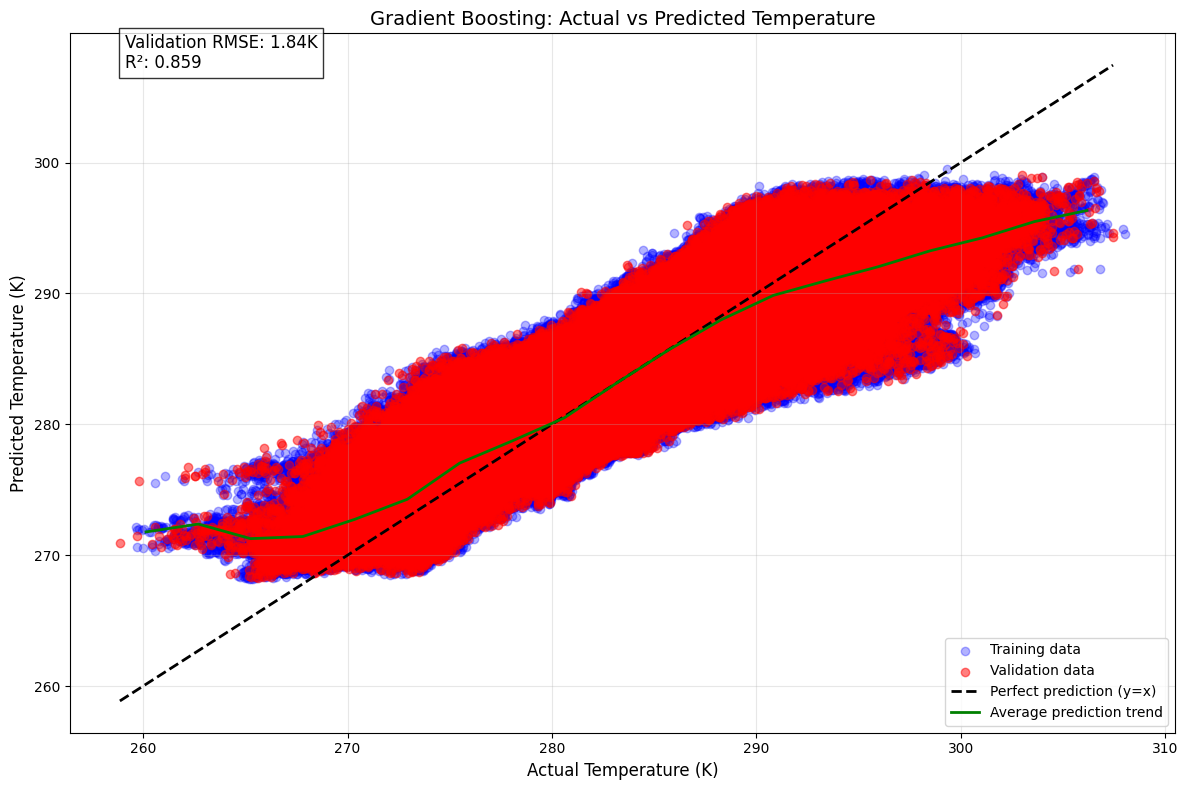

In [60]:
# 1. Improved Actual vs Predicted plot
plt.figure(figsize=(12, 8))

# Add separate colors for training and validation
plt.scatter(y_train, y_train_predictions, alpha=0.3, label='Training data', color='blue')
plt.scatter(y_valid, y_valid_predictions, alpha=0.5, label='Validation data', color='red')

# Add perfect prediction line with label
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 
         'k--', lw=2, label='Perfect prediction (y=x)')

# Add a smoothed trend line to show actual model behavior
from scipy.stats import binned_statistic
bins = np.linspace(y_valid.min(), y_valid.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_valid, y_valid_predictions.ravel(), statistic = 'mean', bins = bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average prediction trend')

# Add metrics to the plot
plt.text(0.05, 0.95, f"Validation RMSE: {np.sqrt(mean_squared_error(y_valid, y_valid_predictions)):.2f}K\nR²: {r2_score(y_valid, y_valid_predictions):.3f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Actual Temperature (K)', fontsize=12)
plt.ylabel('Predicted Temperature (K)', fontsize=12)
plt.title('Gradient Boosting: Actual vs Predicted Temperature', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

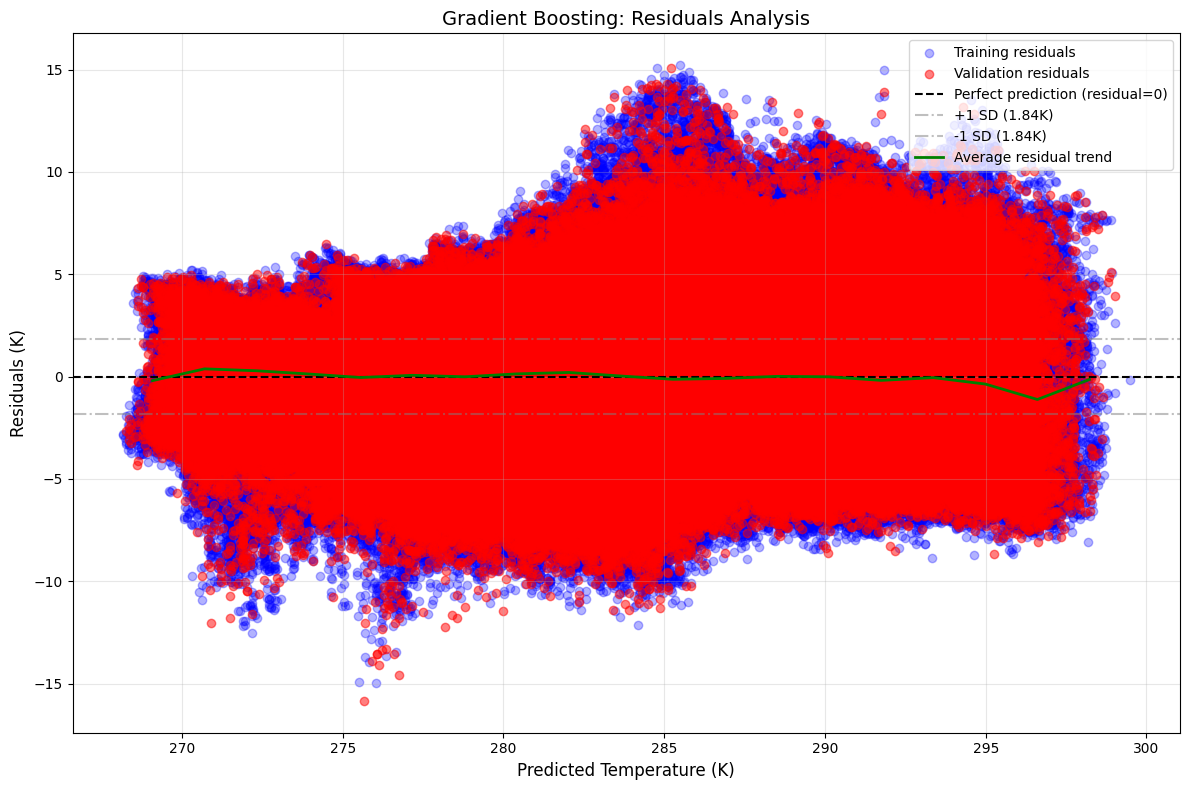

In [61]:
# 2. Improved Residuals Plot
plt.figure(figsize=(12, 8))

# Add separate colors for training and validation
plt.scatter(y_train_predictions, y_train - y_train_predictions.ravel(), alpha=0.3, label='Training residuals', color='blue')
plt.scatter(y_valid_predictions, y_valid - y_valid_predictions.ravel(), alpha=0.5, label='Validation residuals', color='red')

# Add zero line
plt.axhline(y=0, color='k', linestyle='--', label='Perfect prediction (residual=0)')

# Add standard deviation bands
std_dev = np.std(y_valid - y_valid_predictions.ravel())
plt.axhline(y=std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'+1 SD ({std_dev:.2f}K)')
plt.axhline(y=-std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'-1 SD ({std_dev:.2f}K)')

# Add a smoothed trend line for residuals
bins = np.linspace(y_valid_predictions.min(), y_valid_predictions.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_valid_predictions.ravel(), y_valid - y_valid_predictions.ravel(), statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average residual trend')

plt.xlabel('Predicted Temperature (K)', fontsize=12)
plt.ylabel('Residuals (K)', fontsize=12)
plt.title('Gradient Boosting: Residuals Analysis', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

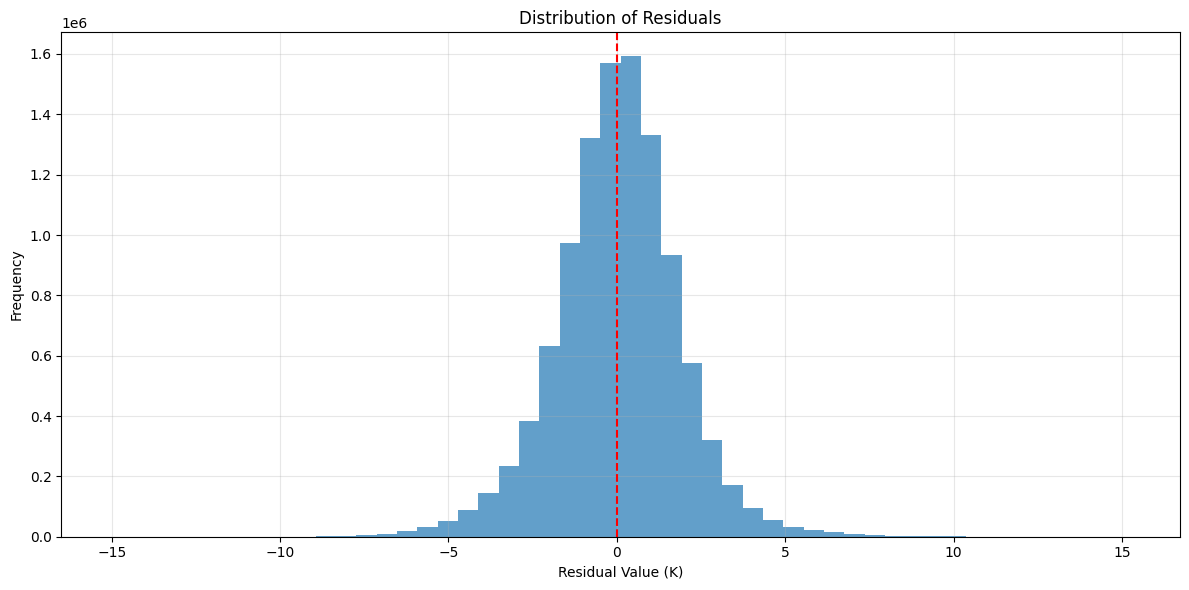

In [62]:
# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(y_train - y_train_predictions.ravel(), bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 2-1.5 Feature Importance

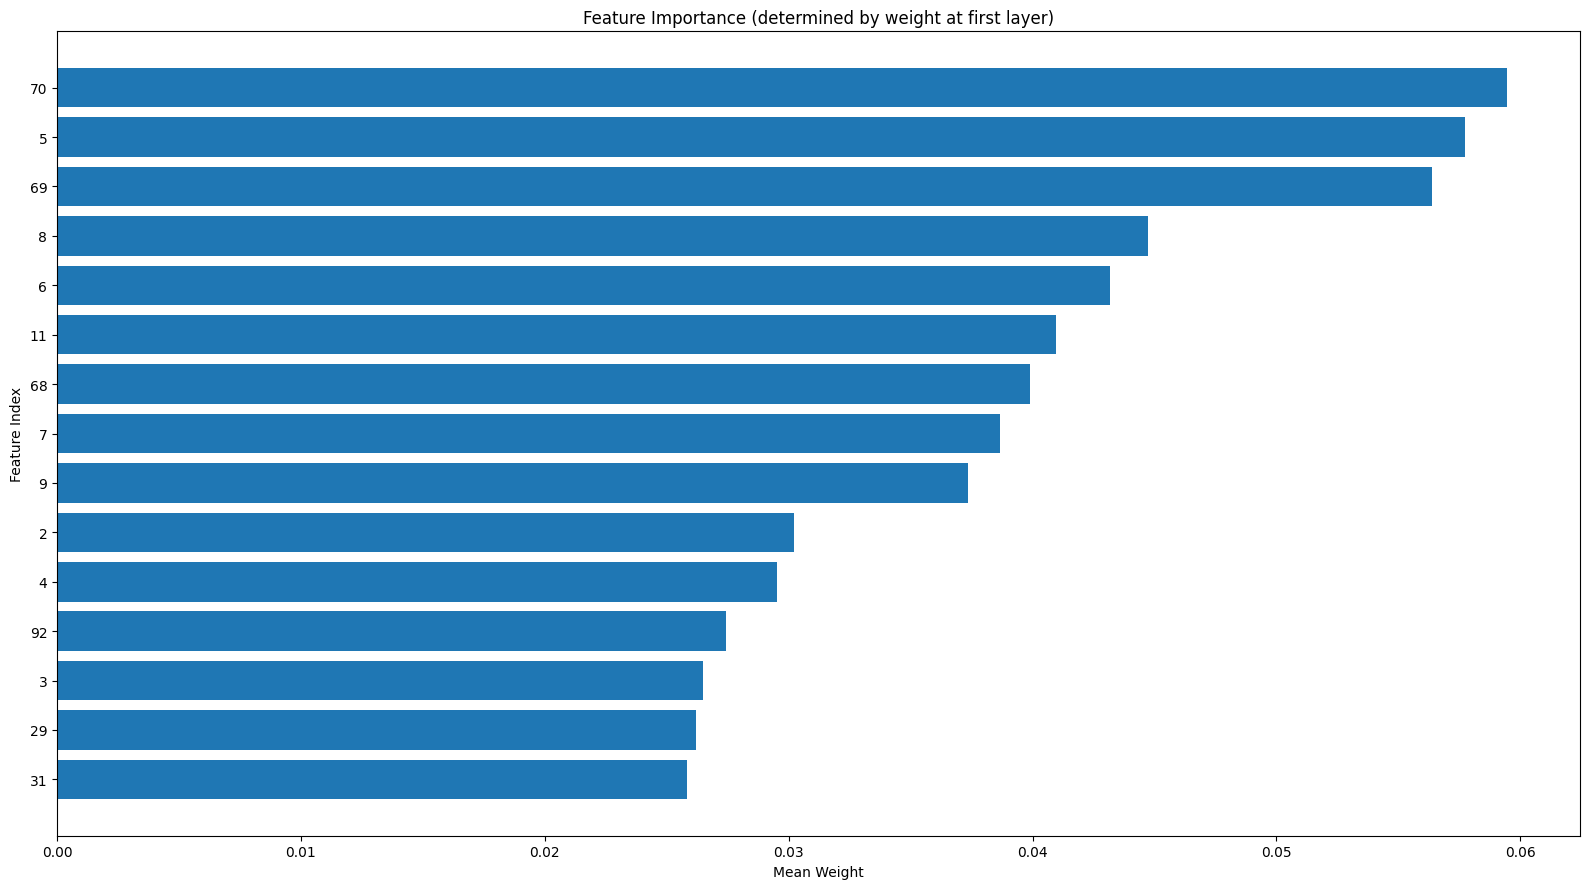

In [63]:
weight_0 = final_neural_network.layers[0].get_weights()[0]
importance = np.mean(np.abs(weight_0), axis = 1)

sorted_importance = np.argsort(importance)[::-1]

M = 15
top_M = sorted_importance[:M][::-1]
feature_ranking = np.arange(len(top_M))

plt.figure(figsize = (16, 9))
plt.barh(feature_ranking, importance[top_M])
plt.yticks(feature_ranking, [f"{index}" for index in top_M])

plt.xlabel("Mean Weight")
plt.ylabel("Feature Index")
plt.title("Feature Importance (determined by weight at first layer)")
plt.tight_layout()
plt.show()